In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# Importing our data
data = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', 
                     encoding='latin1', skiprows=list(range(4)))

# Condense and clean our dataset
data = data.rename(index = str, columns={'Murder and\nnonnegligent\nmanslaughter': 'Murder', 'Property\ncrime': "Property_crime"})
data = data[['Population', 'Murder', 'Robbery', 'Property_crime', 'Burglary']]
data = data.dropna()

# Drop all coumns with population greater than 100000
data = data.sort_values(by ='Population', ascending = False)
data = data[data.Population < 100000]

# Create the new rows for our regression model
data['Pop_squared'] = data['Population']**2

# Preview the data
data.head()

,Population,Murder,Robbery,Property_crime,Burglary,Pop_squared
3,97956.000,8.000,227.000,4090.000,705.000,9595377936.000
126,96667.000,0.000,60.000,2303.000,332.000,9344508889.000
267,87204.000,2.000,9.000,567.000,88.000,7604537616.000
57,80705.000,0.000,17.000,1515.000,99.000,6513297025.000
214,78800.000,0.000,81.000,1391.000,150.000,6209440000.000


In [3]:
# View the column statistics
data.describe()

,Population,Murder,Robbery,Property_crime,Burglary,Pop_squared
count,342.000,342.000,342.000,342.000,342.000,342.000
mean,13468.874,0.272,9.178,293.436,48.374,457433072.494
std,16638.268,1.091,29.628,494.364,97.015,1214093208.009
min,526.000,0.000,0.000,0.000,0.000,276676.000
25%,2979.750,0.000,0.000,39.000,6.000,8878919.250
50%,7074.500,0.000,1.000,111.000,17.000,50049200.500
75%,17611.250,0.000,4.000,331.750,49.000,310156870.750
max,97956.000,10.000,228.000,4090.000,769.000,9595377936.000


In [4]:
# Construct our linear regression model with our X variables 
# and predict Y
regr = linear_model.LinearRegression()
X = data[['Population', 'Murder', 'Robbery', 'Pop_squared']]
Y = data['Property_crime'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 1.49988559e-02 -9.55898302e+00  6.62223072e+00  4.39067785e-08]]

Intercept: 
 [13.15169356]

R-squared:
0.8107096642767955


In [5]:
# Assigning our dependent variables to X, and fitting it to Y
X = data[['Population', 'Murder', 'Robbery', 'Pop_squared','Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 6.37036446e-03  3.65578340e+00 -2.36893618e+00  7.61558391e-08
   3.87285005e+00]]

Intercept: 
 [6.20038379]

R-squared:
0.9329543944064593


In [6]:
# Review the correlation matrix
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Murder,Robbery,Pop_squared,Burglary
Population,1.000,0.490,0.643,0.921,0.723
Murder,0.490,1.000,0.797,0.469,0.665
Robbery,0.643,0.797,1.000,0.634,0.858
Pop_squared,0.921,0.469,0.634,1.000,0.679
Burglary,0.723,0.665,0.858,0.679,1.000


# PCA

In [7]:
# Condensing data to one principal component
pca = PCA(n_components=2)
X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,15.108,-1.054
1,7.572,5.530
2,5.432,4.307
3,4.298,4.617
4,5.396,3.622


In [8]:
# How much of our variance do we retain after limiting our data to 1 component?
pca.explained_variance_ratio_

array([0.75236795, 0.1543409 ])

In [9]:
# Create a new linear regression model with our 1 variable
X = principalDf
Y = data['Property_crime'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[233.27426737  77.65628239]]

Intercept: 
 [293.43567251]

R-squared:
0.8591621413725079


In [10]:
#prediction = principalDf['principal component 1'].apply(lambda x: x*regr.coef_+regr.intercept_)

# Creating our residual graph based on predicted and actual values
predicted = regr.predict(X).ravel()
target = data['Property_crime']
residual = target - predicted

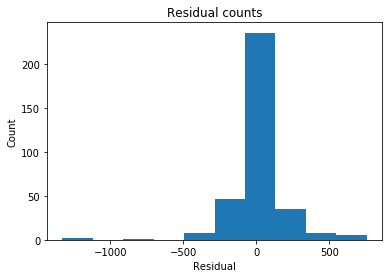

In [11]:
# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

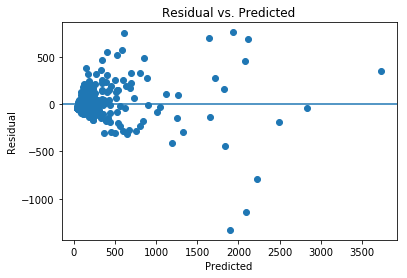

In [12]:
# Create our residual graph
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Cross validation

In [13]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

# Create our model distribution
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

# Create cross validation with 5 groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.014492753623188406
Testing on Sample: 0.043859649122807015


# Writeup

The original features used to predict property crime were population, population squared, murder, and robbery rates. With the first regression model, our model turns out to have a r-squared value of 0.939, a very good score for our model, and an indication that we have picked the correct variables to predict with. Reducing the complexity of the murder and robbery column as we did with the previous exercise (changing values greater than 0 to 1) will decrease our r-squared value, so we're better off leaving the data as it is. Removing features will also reduce the accuracy of our model, while adding more variables (such as burglary) will increase it. This makes sense since adding more variables into the equation should provide more insight into the variables that cause these actions.